In [1]:
import math
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter

2023-12-08 10:33:28.308056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 10:33:28.308083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 10:33:28.308106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 10:33:28.317083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 10:33:29.930789: W tensorflow/compiler/

In [2]:
dataset = []
writer = SummaryWriter("runs/08_12_unconditioned")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

directory = '/nas/home/jalbarracin/datasets/hrir_st'
dataset = []
left_channels = []
right_channels = []

for files in os.listdir(directory):
    f = os.path.join(directory, files)
    wave, sr = torchaudio.load(f, normalize=False)

    left_channel = wave[0].to(dtype=torch.float32)
    right_channel = wave[1].to(dtype=torch.float32)
    
    left_channels.append(left_channel)
    right_channels.append(right_channel)
    
    dataset.append(wave)
    

all_left_channels = torch.cat(left_channels,dim=-1)
all_right_channels = torch.cat(right_channels,dim=-1)

mean_left = all_left_channels.mean(dim=-1)  # Compute mean along the last dimension
std_left = all_left_channels.std(dim=-1)

mean_right = all_right_channels.mean(dim=-1)
std_right = all_right_channels.std(dim=-1)

# Normalize each stereo audio sample
normalized_dataset = [(wave - torch.tensor([mean_left, mean_right]).unsqueeze(-1)) / torch.tensor([std_left, std_right]).unsqueeze(-1) for wave in dataset]

'''
target_min = -1.0
target_max = 1.0

# Find the maximum absolute value in the entire dataset
max_abs = max(torch.max(torch.abs(wave)) for wave in dataset)

# Normalize each audio sample to the target range
normalized_dataset = [wave / max_abs * target_max for wave in dataset]
'''

Using device: cuda


'\ntarget_min = -1.0\ntarget_max = 1.0\n\n# Find the maximum absolute value in the entire dataset\nmax_abs = max(torch.max(torch.abs(wave)) for wave in dataset)\n\n# Normalize each audio sample to the target range\nnormalized_dataset = [wave / max_abs * target_max for wave in dataset]\n'

In [3]:
print(f"Dataset length: {len(normalized_dataset)}")
print(f"Sample channels and length: {normalized_dataset[0].shape}")

Dataset length: 3096
Sample channels and length: torch.Size([2, 256])


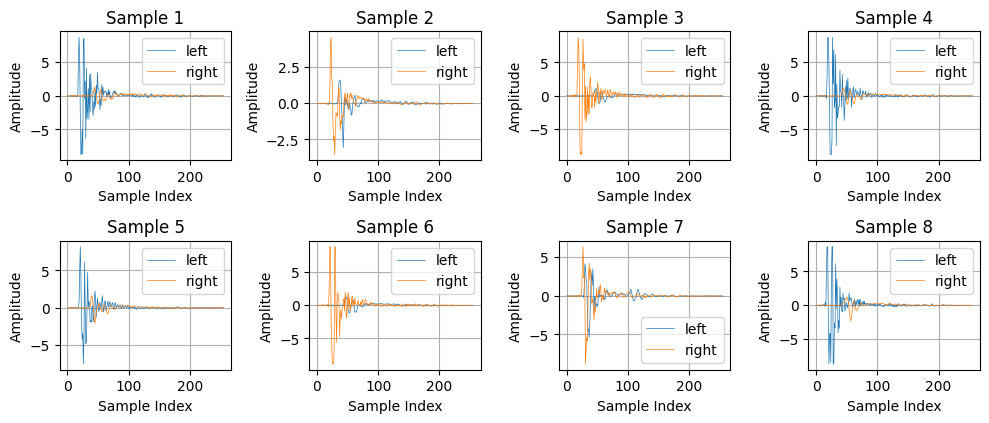

In [4]:
def show_waveforms(dataset, num_samples=20, cols=4):
    """ Plots some samples from the audio dataset """
    plt.figure(figsize=(10, 6)) 
    for i, item in enumerate(dataset):
        if i == num_samples:
            break
        if isinstance(item, tuple):
            waveform, _ = item
        else:
            waveform = item
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.plot(waveform[0].numpy(), label='left', linewidth=0.5)
        plt.plot(waveform[1].numpy(), label='right', linewidth=0.5)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        #plt.ylim([-1.0,1.0])
    plt.tight_layout()
    plt.show()
show_waveforms(normalized_dataset, num_samples=8, cols=4)

In [5]:
def collate_fn(batch):
    # Assuming each element in batch is a tensor of shape (2, 256)
    return torch.stack([item.squeeze(0) for item in batch])

In [6]:
BATCH_SIZE = 1 # len(dataset) // 4
dataloader = torch.utils.data.DataLoader(
    normalized_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [7]:
audio_test = next(iter(dataloader))[0]
print(audio_test.shape)

torch.Size([2, 256])


In [8]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an audio and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 600
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [11]:
def show_tensor_waveform(waveform):
    reverse_transforms = [
        lambda t: t.numpy(),        # Convert tensor to NumPy array
        lambda t: np.squeeze(t),    # Remove singleton dimensions
    ]

    # Take the first waveform of the batch
    if len(waveform.shape) == 3:
        waveform = waveform[0, :, :]

    for transform in reverse_transforms:
        waveform = transform(waveform)

     # Plot left channel (index 0)
    plt.plot(waveform[0], label="Left Channel")

    # Plot right channel (index 1)
    plt.plot(waveform[1], label="Right Channel")

    #plt.ylim([-1.0,1.0])
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    #plt.legend()
    #plt.show()

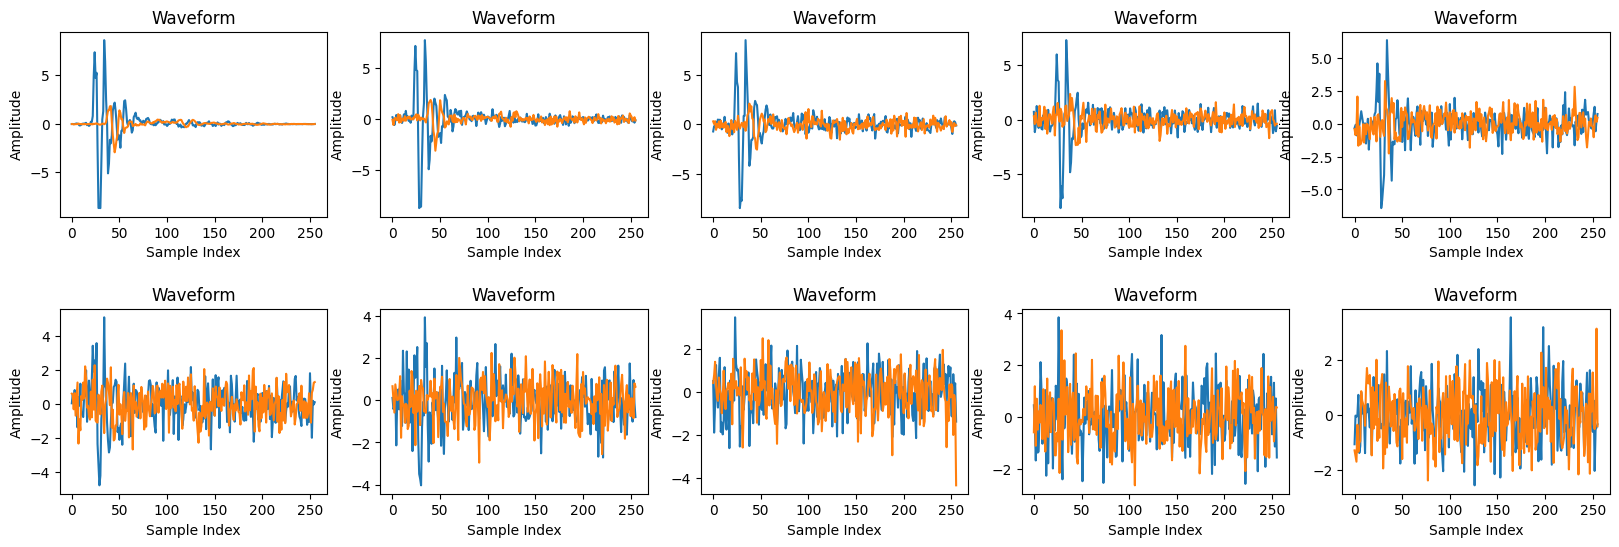

In [12]:
# Simulate forward diffusion
audio_test = next(iter(dataloader))[0]

plt.figure(figsize=(20,6))
plt.axis('off')
num_rows = 2
num_img_row = 5
num_images = num_rows * num_img_row
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    subplot_idx = int(idx / stepsize) + 1
    row = (subplot_idx - 1) // num_img_row + 1
    col = (subplot_idx - 1) % num_img_row + 1
    plt.subplot(num_rows, num_img_row, subplot_idx)
    au, noise = forward_diffusion_sample(audio_test, t)
    #print(au.shape)
    show_tensor_waveform(au)

plt.subplots_adjust(hspace=0.5)

In [13]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv1d(2 * in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm1d(out_ch)
        self.bnorm2 = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Remove the last dimension
        #print("x before", x.shape)
        x = x.squeeze(2)
        #print("x shape",x.shape)
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))  # Adjust here
        #print("After conv1 shape:", h.shape)
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last dimension
        time_emb = time_emb.unsqueeze(-1)
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        #print("After conv2 shape:", h.shape)
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
       
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        audio_channels = 2  # Adjust for stereo audio
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 2  # Adjust for stereo audio
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv1d(audio_channels, down_channels[0], kernel_size=3, padding=1)  # Adjust here

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) \
                                  for i in range(len(up_channels) - 1)])

        # Output layer
        self.output = nn.Conv1d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        #print("Time embedding shape:", t.shape)
        # Initial conv
        x = self.conv0(x)  
        #print("After conv0 shape:", x.shape)
        # Unet
        residual_inputs = []
        for i, down in enumerate(self.downs):
            #print("hola")
            x = down(x, t)
            #print(f"After downsampling block {i} shape:", x.shape)
            residual_inputs.append(x)
        for i, up in enumerate(self.ups):
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
            #print(f"After upsampling block {i} shape:", x.shape)
        # Assuming the final output layer is 1D
        return self.output(x)


# Example usage
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  18569314


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(128, 128, kernel_size=(4,), stride=(2,), padding=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(256, 256, kernel_si

In [14]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [15]:
AUDIO_SIZE = 256

@torch.no_grad()
def sample_timestep(audio, t):
    """
    Calls the model to predict the noise in the audio and returns 
    the denoised audio. 
    Applies noise to this audio, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, audio.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, audio.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, audio.shape)
    #print("Audio shape:", audio.shape)
    # Call model (current audio - noise prediction)
    # Concatenate both channels along the channel dimension
    model_mean = sqrt_recip_alphas_t * (
        audio - betas_t * model(audio, t) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = get_index_from_list(posterior_variance, t, audio.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(audio)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_audio():
    # Sample noise
    audio = torch.randn((1, 2, AUDIO_SIZE), device=device)  # Adjust for stereo audio
    plt.figure(figsize=(12, 2))
    plt.axis('off')
    num_audios = 5
    stepsize = int(T / num_audios)
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        audio = sample_timestep(audio, t)
        # Clip the audio to a reasonable range (-1 to 1)
        #audio = torch.clamp(audio, -1.0, 1.0)
        #print(audio.shape)
        if i % stepsize == 0:
            plt.subplot(1, num_audios, int(i / stepsize) + 1)
            #print("audio shape:", audio.shape)
            #print("left:",len(audio[0][0]))
            #print("right:",len(audio[0][1]))
            #hrtf = np.asarray([audio[0][0],audio[0][1]]).swapaxes(-1,0)
            
            show_tensor_waveform(audio[0].detach().cpu())  # Display left channel
            #show_tensor_waveform(audio[0][1].detach().cpu())  # Display right channel
            #print("audio shape:", audio[0].shape)
            #print('lol')
            torchaudio.save(f'generated_st_audio.wav', audio[0].cpu(), 44100)  # Save the stereo audio
    plt.subplots_adjust(hspace=0.5)
    plt.show()


Epoch 0 | step 000 Loss: 0.8678234815597534 


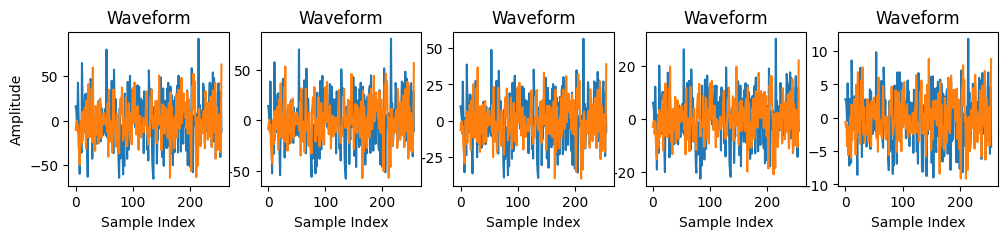

Epoch 5 | step 000 Loss: 0.16691705584526062 


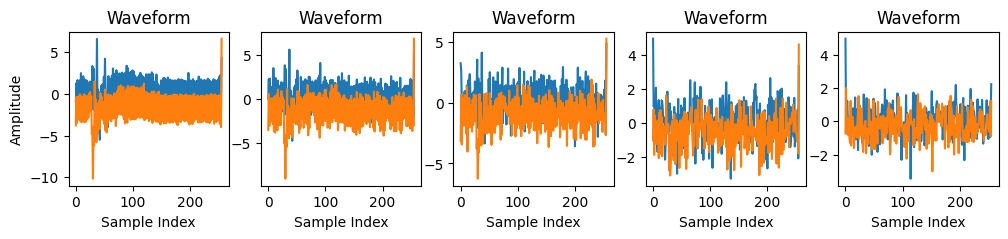

Epoch 10 | step 000 Loss: 0.14596736431121826 


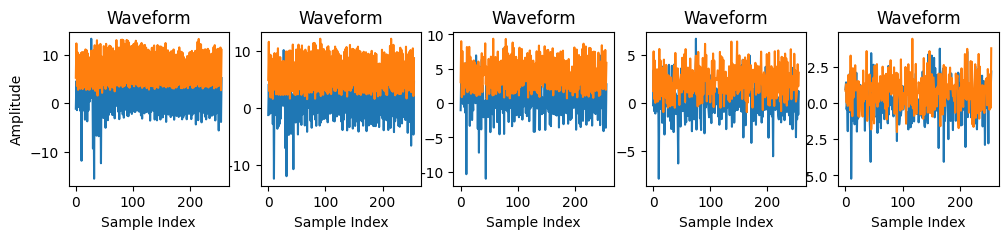

Epoch 15 | step 000 Loss: 0.22996658086776733 


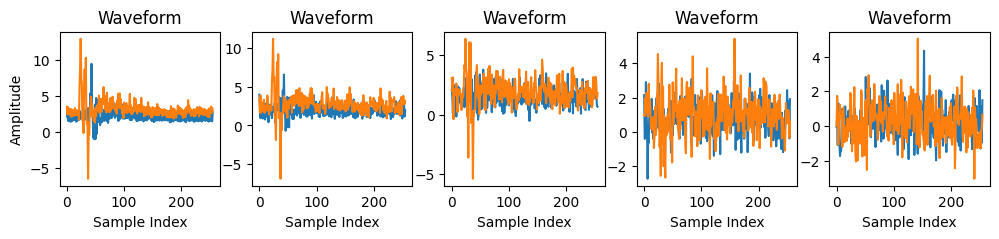

Epoch 20 | step 000 Loss: 0.2049480825662613 


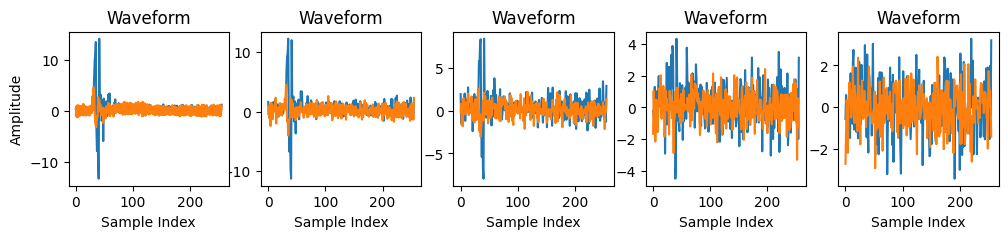

Epoch 25 | step 000 Loss: 0.11838633567094803 


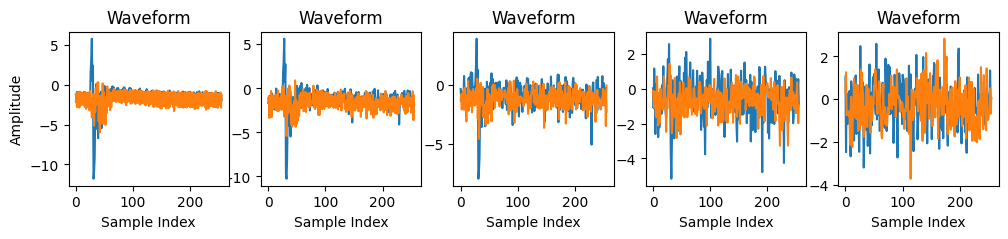

Epoch 30 | step 000 Loss: 0.19036146998405457 


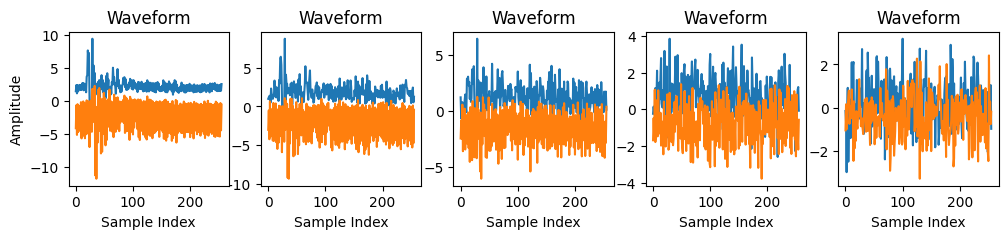

Epoch 35 | step 000 Loss: 0.14914923906326294 


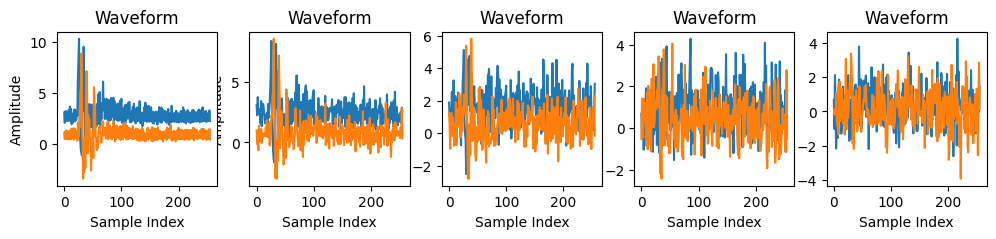

Epoch 40 | step 000 Loss: 0.1886342614889145 


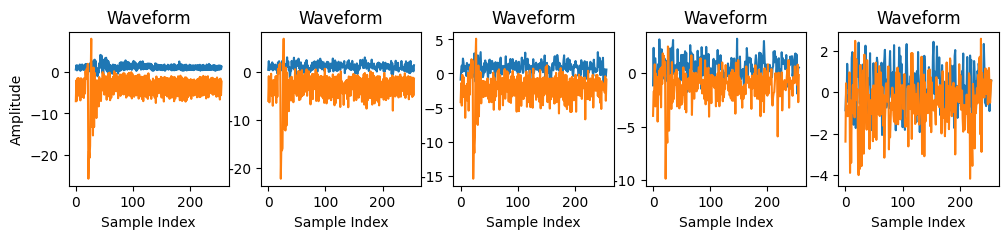

Epoch 45 | step 000 Loss: 0.1736387312412262 


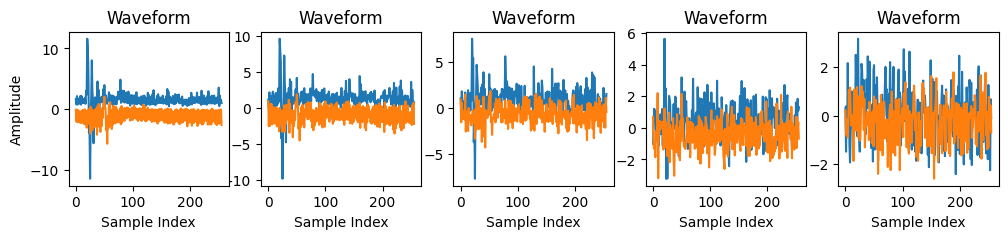

Epoch 50 | step 000 Loss: 0.1704094409942627 


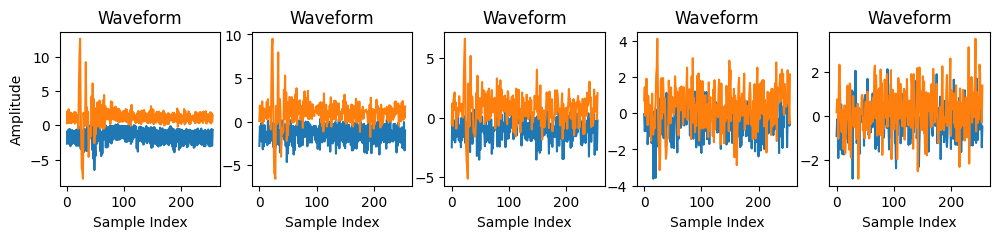

Epoch 55 | step 000 Loss: 0.12791013717651367 


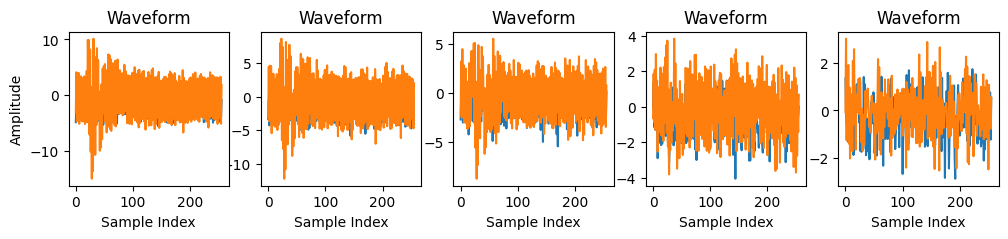

Epoch 60 | step 000 Loss: 0.08680175244808197 


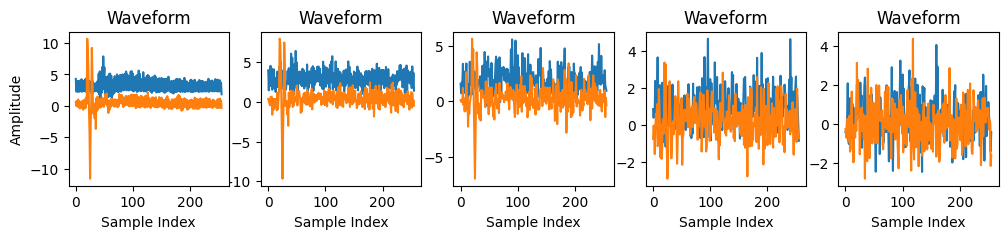

Epoch 65 | step 000 Loss: 0.11755891144275665 


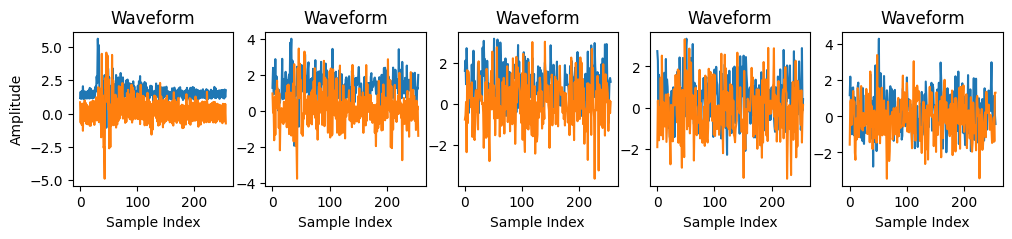

Epoch 70 | step 000 Loss: 0.3339982032775879 


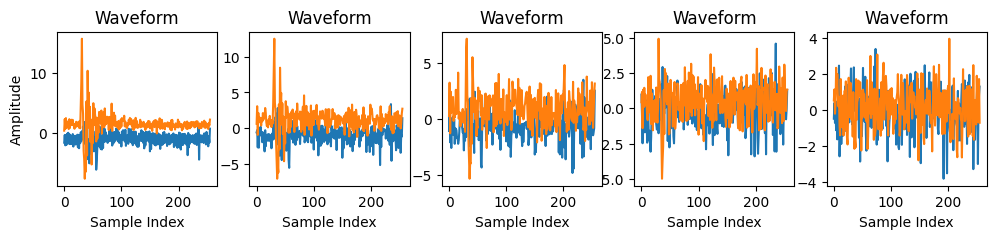

Epoch 75 | step 000 Loss: 0.09324266761541367 


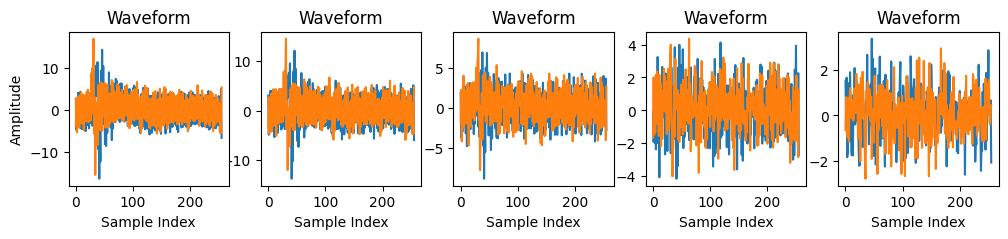

Epoch 80 | step 000 Loss: 0.20012600719928741 


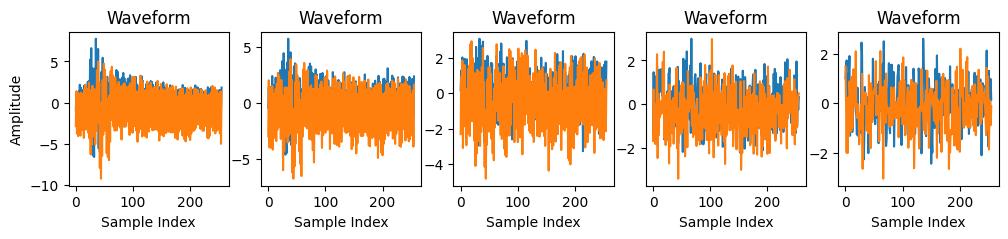

Epoch 85 | step 000 Loss: 0.21572181582450867 


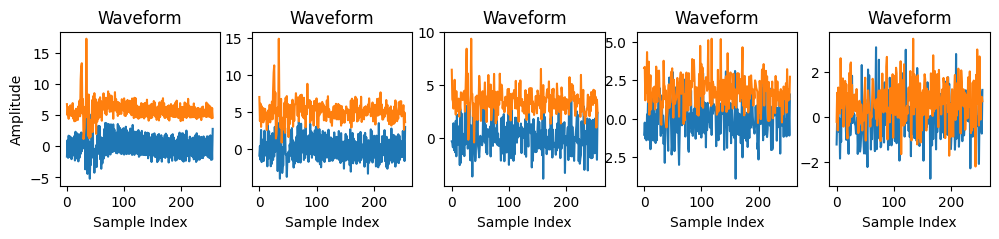

Epoch 90 | step 000 Loss: 0.10371610522270203 


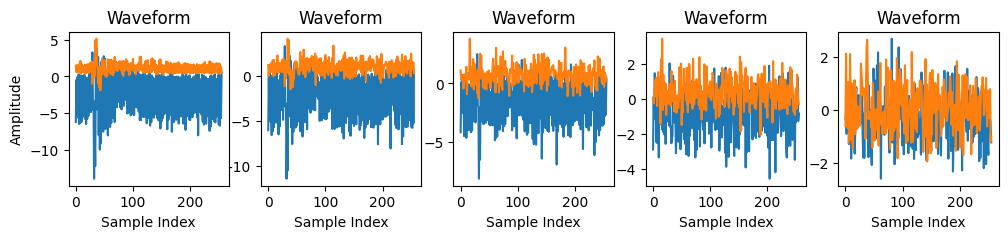

Epoch 95 | step 000 Loss: 0.15139862895011902 


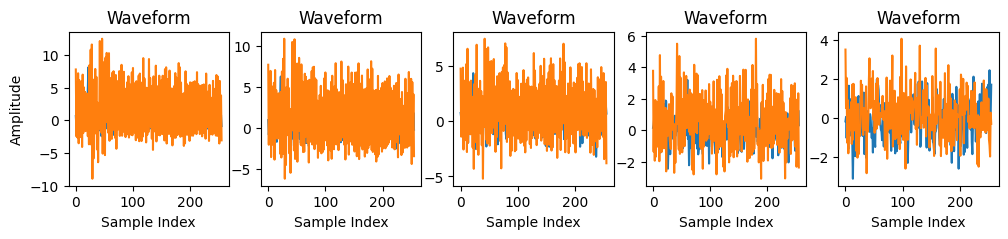

Epoch 100 | step 000 Loss: 0.07723855972290039 


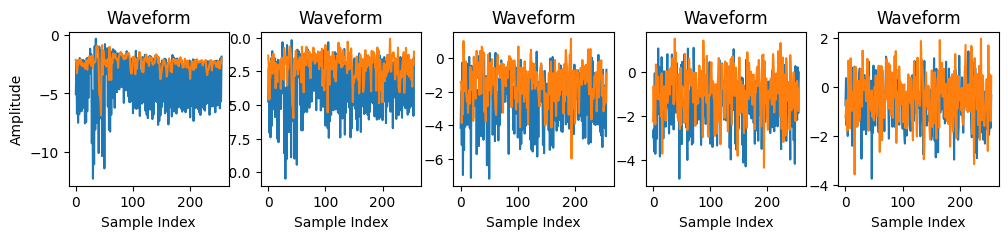

Epoch 105 | step 000 Loss: 0.08852769434452057 


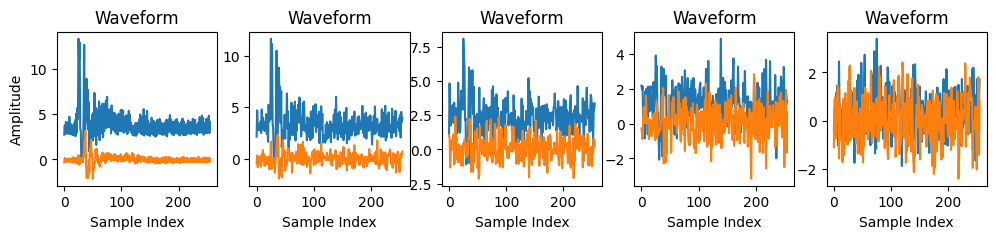

Epoch 110 | step 000 Loss: 0.07649455964565277 


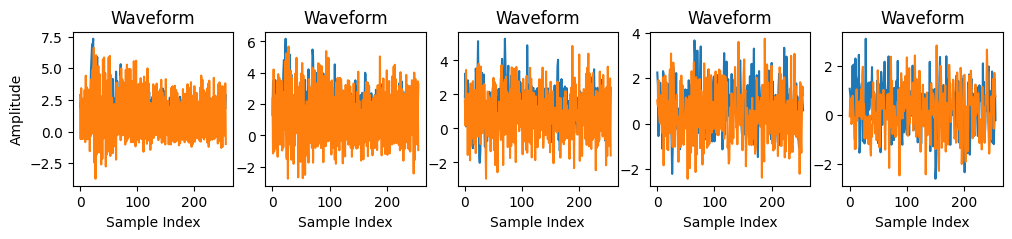

Epoch 115 | step 000 Loss: 0.14347457885742188 


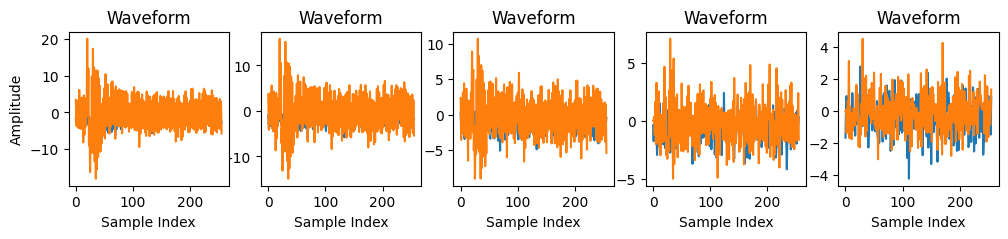

Epoch 120 | step 000 Loss: 0.0906258374452591 


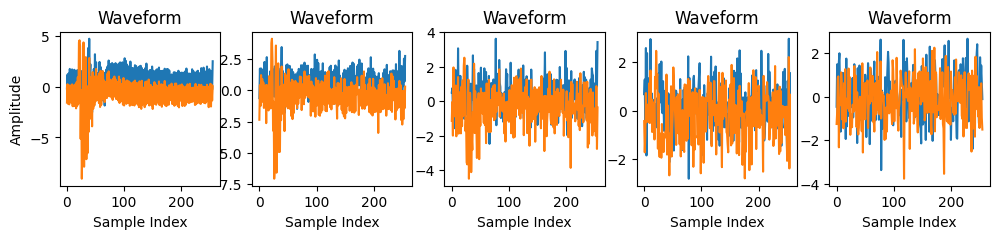

Epoch 125 | step 000 Loss: 0.2614082396030426 


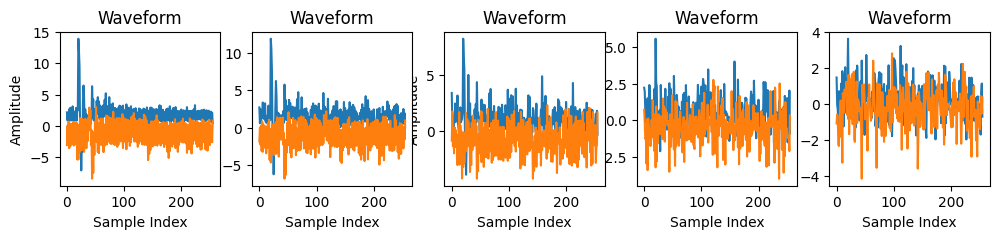

Epoch 130 | step 000 Loss: 0.14853829145431519 


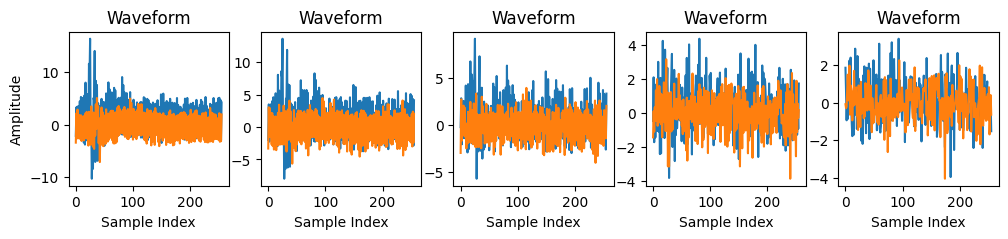

Epoch 135 | step 000 Loss: 0.1527218073606491 


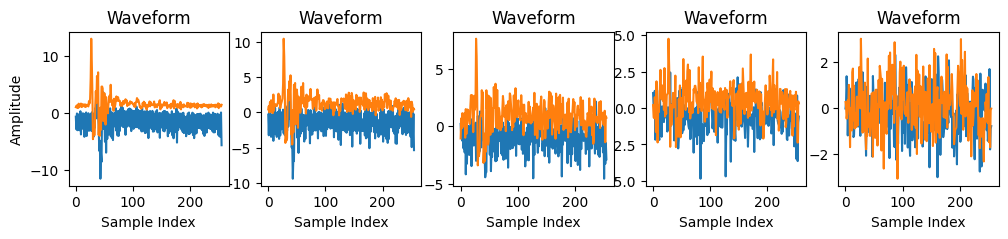

Epoch 140 | step 000 Loss: 0.3683207333087921 


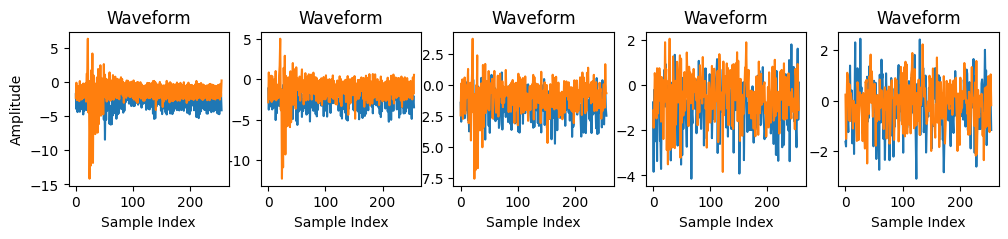

Epoch 145 | step 000 Loss: 0.5755035877227783 


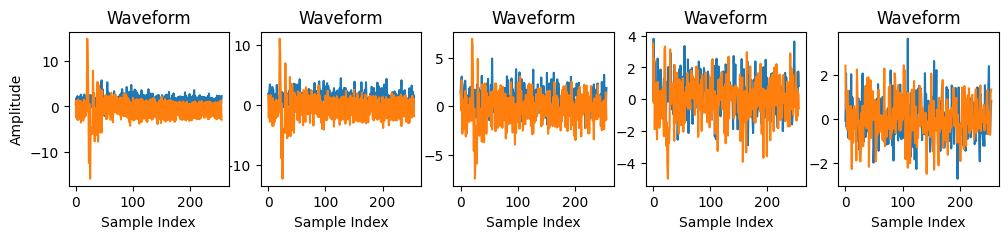

Epoch 150 | step 000 Loss: 0.13003762066364288 


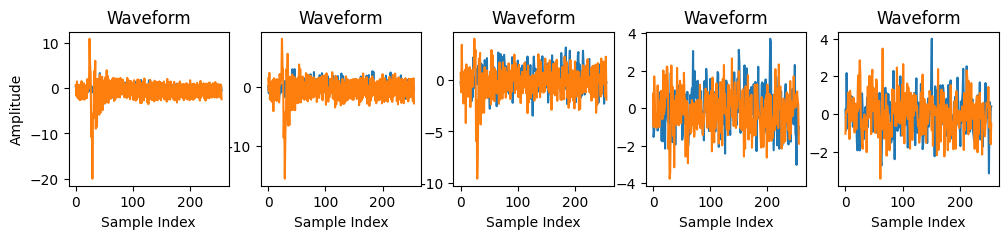

Epoch 155 | step 000 Loss: 0.09310773015022278 


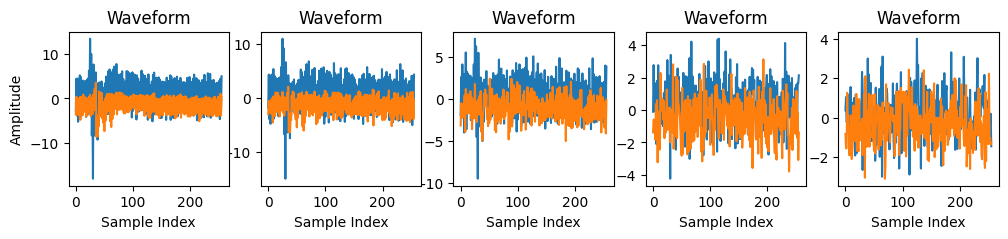

Epoch 160 | step 000 Loss: 0.11361376941204071 


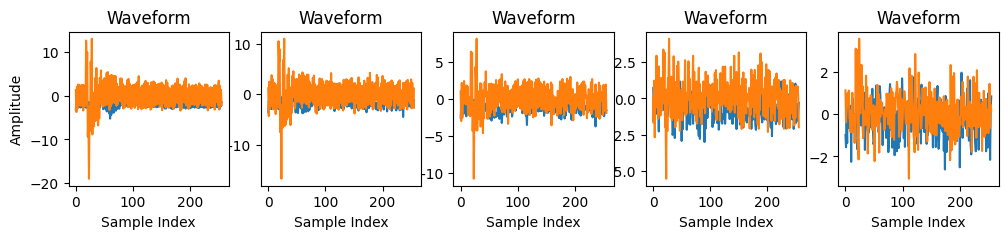

Epoch 165 | step 000 Loss: 0.40919238328933716 


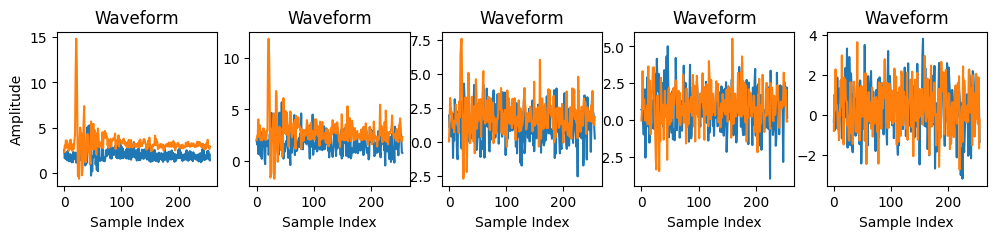

Epoch 170 | step 000 Loss: 0.10626852512359619 


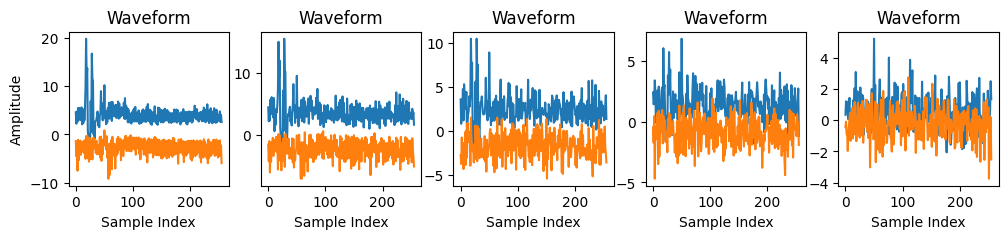

Epoch 175 | step 000 Loss: 0.30284303426742554 


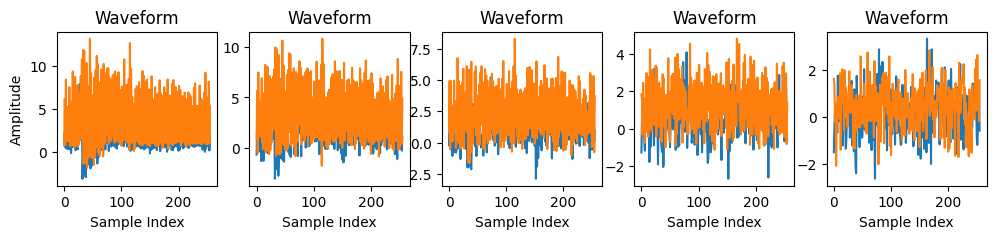

Epoch 180 | step 000 Loss: 0.2354198694229126 


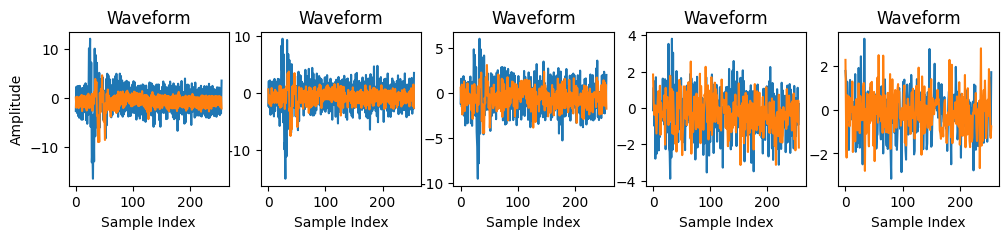

Epoch 185 | step 000 Loss: 0.08697597682476044 


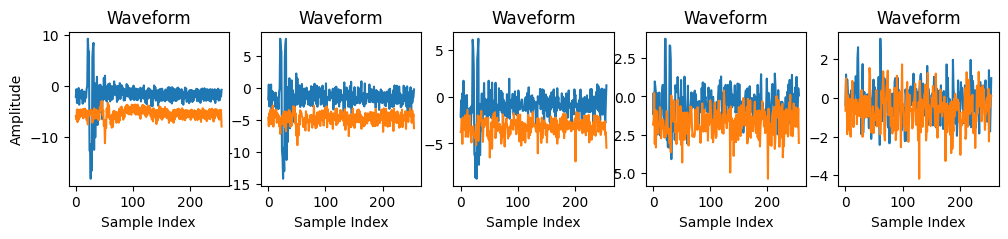

Epoch 190 | step 000 Loss: 0.10690678656101227 


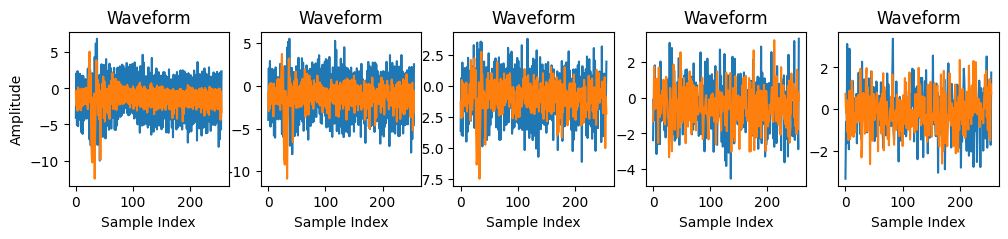

Epoch 195 | step 000 Loss: 0.13467901945114136 


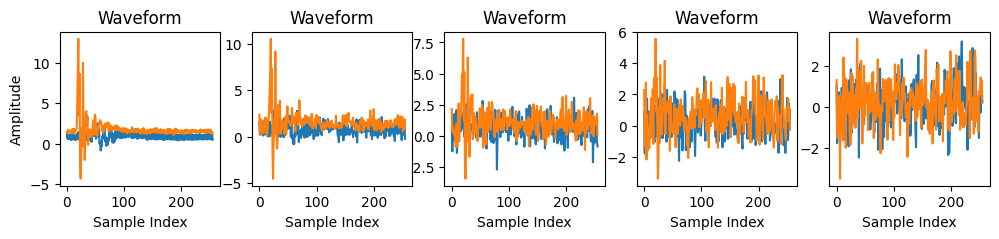

Training complete. Saved checkpoints.


In [16]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 200

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        x_input = batch[0].unsqueeze(0) 
        #print("shape input", x_input.shape)
        loss = get_loss(model, x_input, t)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_audio()
            
    
    # Save model and optimizer states after each epoch
    checkpoint_path = f"checkpoint_epoch_{epoch}.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, checkpoint_path)
    
writer.flush()
print("Training complete. Saved checkpoints.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256, 2)


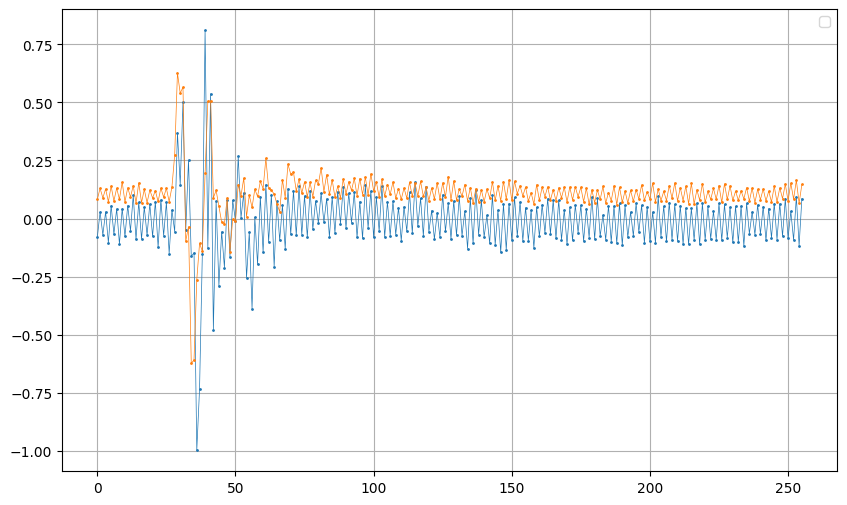

In [19]:
import soundfile as sf
#mse
generated_hrir, sr = sf.read('generated_st_audio.wav')
print(generated_hrir.shape)
plt.figure(figsize=(10,6))
plt.plot(generated_hrir, linewidth=0.5,  marker='o', markersize=1)
#plt.plot(generated_hrir[1], label='right', linewidth=0.5,  marker='o', markersize=1)
plt.grid()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256, 2)


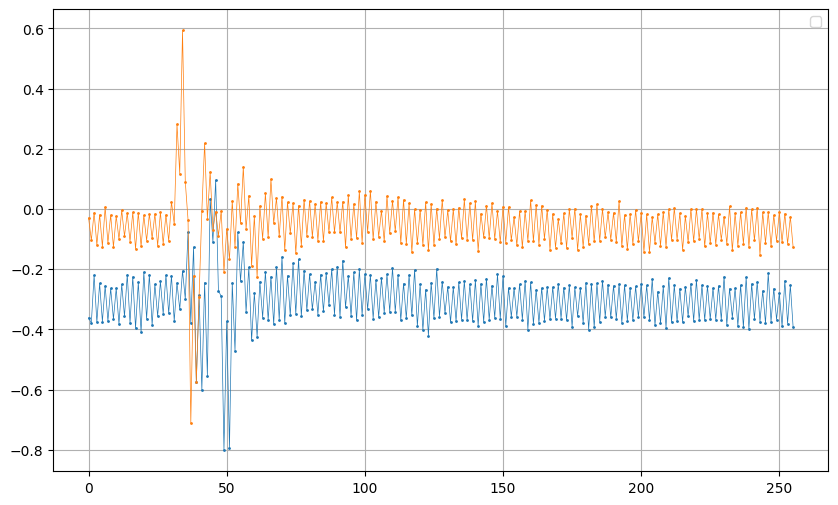

In [4]:
#l1
generated_hrir, sr = sf.read('/nas/home/jalbarracin/ddpm/results/21_nov/generated_st_audio.wav')
print(generated_hrir.shape)
plt.figure(figsize=(10,6))
plt.plot(generated_hrir, linewidth=0.5,  marker='o', markersize=1)
#plt.plot(generated_hrir[1], label='right', linewidth=0.5,  marker='o', markersize=1)
plt.grid()
plt.legend()
plt.show()

In [5]:
import scipy.signal
import IPython
test_signal, sr = sf.read('test_signal.wav')
print(test_signal.shape)
binaural_left = scipy.signal.fftconvolve(test_signal,generated_hrir[0])
binaural_right = scipy.signal.fftconvolve(test_signal,generated_hrir[1])
print(len(binaural_right))
print(len(binaural_left))
binaural_st = np.asarray([binaural_left,binaural_right]).swapaxes(-1,0)
sf.write('processed_audio_st.wav',binaural_st,44100)

(119190,)
119191
119191
